In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

#Viewers
from hsiViewer import hsi_viewer as hv
from hsiViewer import hsi_layers_viewer as hvl

## Download the hyperspectral image

In this case, we will be using a hyperspectral image from the RIT test over Cooke City, Montana. (https://dirsapps.cis.rit.edu/blindtest/)

In [2]:
# load the Cooke City hyperspectral iamge
fname = './C/spectral_images/Detection_Imagery_Cooke_City_RIT/self_test_refl'
fname_hdr = './C/spectral_images/Detection_Imagery_Cooke_City_RIT/self_test_refl.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (280, 800, 126)
Shape of imList = (224000, 126)


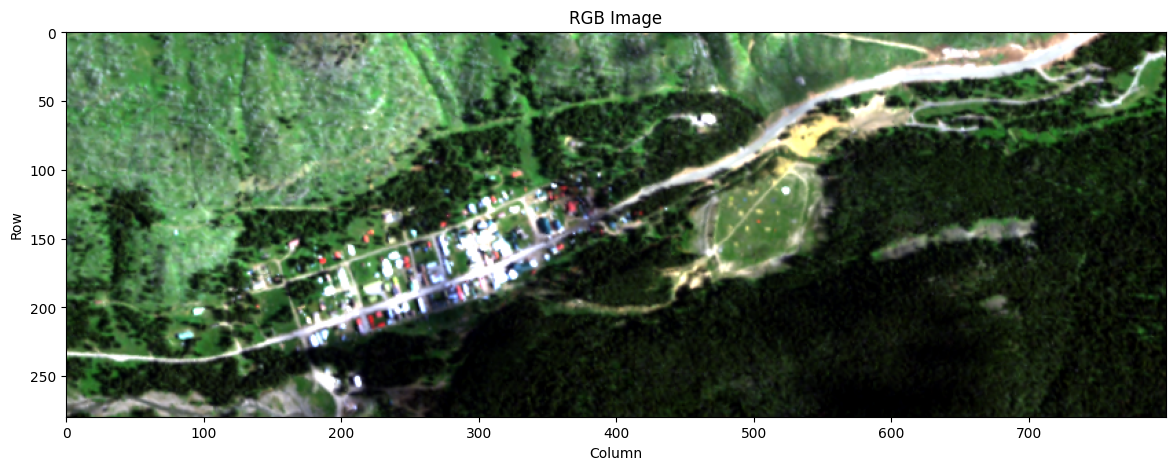

In [3]:
# display the image
sm2.display_RGB(imArr, wl_im, rotate=False)
plt.title('RGB Image');

# Download the Spectral Library for Target Detection

In [4]:
fname = './C/spectral_libraries/Detection_Library_Cooke_City_RIT/Cooke_City_Targets'
fname_hdr = './C/spectral_libraries/Detection_Library_Cooke_City_RIT/Cooke_City_Targets.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname+'.hdr', fname)
wl_lib = np.asarray(lib.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra


### Resampling the library wavelength to match the image.

In [5]:
resampler = spectral.BandResampler(wl_lib, wl_im)
spec = resampler(lib.spectra.T).T

print(f'The shape of the spectral library is {spec.shape}.')
print(f'({spec.shape[0]} spectra with {spec.shape[1]} bands.)')

wl = wl_im # the wavelengths for the image and the resampled library

The shape of the spectral library is (18, 126).
(18 spectra with 126 bands.)


# Use BIC to select GMM with best # of clusters for image

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


class GaussianMixtureWithPrint(GaussianMixture):
    def fit(self, X, y=None):
        """Override the fit method to add a print statement."""
        print(f"Fitting GMM with {self.n_components} components and '{self.covariance_type}' covariance...")
        result = super().fit(X, y)
        print(f"Completed fit for {self.n_components} components.")
        return result

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(8, 15),
    "covariance_type": ["full"],
}

grid_search = GridSearchCV(
    GaussianMixtureWithPrint(), param_grid=param_grid, scoring=gmm_bic_score, n_jobs=-1
)

grid_search.fit(imList)

Fitting GMM with 8 components and 'full' covariance...
Fitting GMM with 8 components and 'full' covariance...
Fitting GMM with 8 components and 'full' covariance...
Fitting GMM with 8 components and 'full' covariance...
Fitting GMM with 9 components and 'full' covariance...
Fitting GMM with 9 components and 'full' covariance...
Fitting GMM with 9 components and 'full' covariance...
Fitting GMM with 8 components and 'full' covariance...
Completed fit for 8 components.
Fitting GMM with 9 components and 'full' covariance...
Completed fit for 8 components.
Fitting GMM with 9 components and 'full' covariance...
Completed fit for 8 components.
Fitting GMM with 10 components and 'full' covariance...
Completed fit for 9 components.
Fitting GMM with 10 components and 'full' covariance...
Completed fit for 8 components.
Fitting GMM with 10 components and 'full' covariance...
Completed fit for 9 components.
Fitting GMM with 10 components and 'full' covariance...
Completed fit for 8 components.
Fi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Completed fit for 14 components.
Fitting GMM with 8 components and 'full' covariance...
Completed fit for 8 components.


GridSearchCV(estimator=GaussianMixtureWithPrint(), n_jobs=-1,
             param_grid={'covariance_type': ['full'],
                         'n_components': range(8, 15)},
             scoring=<function gmm_bic_score at 0x13bc2b1a0>)

### Grid Search Result Table

In [33]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance     BIC score
0                    8               full  3.501404e+07
1                    9               full  3.512196e+07
2                   10               full  3.515794e+07
3                   11               full  3.525847e+07
4                   12               full  3.538019e+07

### Save and Load Best Model

In [34]:
import pickle

# Save the best model
best_model = grid_search.best_estimator_

# Save the model to a file
with open('outputs/best_gmm_model.pkl','wb') as f:
    pickle.dump(best_model,f)

In [ ]:
# Using pickle
with open("outputs/best_gmm_model.pkl", "rb") as f:
    best_model = pickle.load(f)

### Save Means and Covariances

In [35]:
import pandas as pd
import numpy as np

# Assuming `best_model` is the fitted GMM
means = best_model.means_
covariances = best_model.covariances_

# Prepare data for the DataFrame
data = {
    "Cluster": [f"Cluster {i+1}" for i in range(best_model.n_components)],
    "Mean": [mean.tolist() for mean in means],
    "Covariance": [cov.tolist() for cov in covariances],
}

# Create DataFrame
df_clusters = pd.DataFrame(data)

# Save the DataFrame to a CSV file (optional)
df_clusters.to_csv("outputs/gmm_clusters.csv", index=False)

# Display the DataFrame
df_clusters


Cluster                                               Mean  \
0  Cluster 1  [4.517836122054157, 14.326147180141348, 19.819...   
1  Cluster 2  [223.76363097724996, 239.96907346404103, 264.9...   
2  Cluster 3  [149.5347459983053, 163.8298921211274, 182.579...   
3  Cluster 4  [268.50878240912346, 289.50964421375915, 323.3...   
4  Cluster 5  [475.2637246092761, 498.0854358251679, 549.790...   
5  Cluster 6  [119.53136994082061, 133.9900595915998, 150.74...   
6  Cluster 7  [535.6368301598266, 553.1428263096469, 599.557...   
7  Cluster 8  [34.84857423242929, 46.678754668670024, 55.358...   

                                          Covariance  
0  [[174.64151158050979, 173.6815111336417, 196.3...  
1  [[3812.197128245218, 3891.4648164087134, 4227....  
2  [[8052.270525102499, 8259.096157423368, 8999.6...  
3  [[10957.129228378553, 11180.837891855937, 1217...  
4  [[38394.905103797886, 38446.89283612933, 40759...  
5  [[2661.3358850276504, 2719.846712364818, 2960....  
6  [[276550.15846779884, 276183.70083129185, 2927...  
7  [[559.3472417649728, 557.6713536539162, 603.54...

In [48]:
## Get the mean and covariance of each cluster, Whiten the image and spectra, and compute the MF/ACE values
# Collect targets identified from each cluster (anything past 6 SD), Plot and compute FP and TP rates
fa_df = pd.DataFrame()
tp_df = pd.DataFrame()
roi_df = pd.DataFrame()

for cluster in range(best_model.n_components):
    #Calculate Mean and Covariance
    C = df_clusters['Covariance'][cluster]
    m = df_clusters['Mean'][cluster]

    # Whiten the Image
    evals,evecs = np.linalg.eig(C)
    DiagMatrix = np.diag(evals**(-1/2))
    W = np.matmul(evecs,DiagMatrix)
    ImListDemean = imList - m
    WimList = np.matmul(W.T, ImListDemean.T).T

    # Whiten the Spectral Library
    SpecDemean = spec - m
    Wspec = np.matmul(W.T, SpecDemean.T).T
    
    # Compute MF
    ntargets = Wspec.shape[0]
    numerator = np.matmul(WimList,Wspec.T)
    denom = np.sum(Wspec**2, axis=1)
    MF = np.squeeze(numerator / denom)
    MF = np.reshape(MF, (im.nrows, im.ncols, ntargets))

    # Compute ACE
    numerator = np.matmul(WimList,Wspec.T)
    XX = np.reshape(np.sqrt(np.sum(WimList**2,axis=1)), (224000,1))
    TT = np.reshape(np.sqrt(np.sum(Wspec**2,axis=1)),(18,1))
    denominator = np.matmul(XX,TT.T)
    ACE = np.squeeze(numerator / denominator)
    ACE = np.reshape(ACE, (im.nrows, im.ncols, ntargets))


    fa_rate = []
    tp_rate = []
    rois_len = []

    for z in formulas:

        mf_fa_rate = []
        mf_tp_rate = []
        mf_rois_len = []

        for i in range(len(detector_class_idx)):
            # Detected Targets
            if z == 'MF':
                MF_threshold = MF[:,:,detector_class_idx[i]].squeeze()
            else:
                MF_threshold = ACE[:,:,detector_class_idx[i]].squeeze()
            m = np.mean(MF_threshold)
            s = np.std(MF_threshold)
            #MF_threshold[MF_threshold<0] = 0
            detections = np.where(MF_threshold>m+6*s)
            detections = [list(i) for i in zip(detections[0], detections[1])]

            # ROIS
            rois = groundtruth_classes[roi_sub_name[i]]['locations']
            rois = [[int(num) for num in sublist] for sublist in rois]

            #Guards
            guards = groundtruth_classes[roi_guard_name[i]]['locations']
            guards = [[int(num) for num in sublist] for sublist in guards]

            false_alarms = [item for item in detections if item not in rois and item not in guards]
            true_positives = [item for item in detections if item in rois]
            mf_fa_rate.append(len(false_alarms))
            mf_tp_rate.append(len(true_positives))
            mf_rois_len.append(len(rois))

        ############ FALSE ALARM RATE TABLE ############
        fa_rate.append(mf_fa_rate)
        tp_rate.append(mf_tp_rate)
        rois_len.append(mf_rois_len)

    # False Alarm Rates
    fa_df = pd.DataFrame(fa_rate, columns=detector_class_name)
    fa_df.index = formulas
    for i in range(len(fa_df)):
        fa_df.iloc[i] += fa_df.iloc[i]

    # True Positive Rates
    tp_df = pd.DataFrame(tp_rate, columns=detector_class_name)
    tp_df.index = formulas
    for i in range(len(tp_df)):
        tp_df.iloc[i] += tp_df.iloc[i]

    # Rois Length
    roi_df = pd.DataFrame(rois_len, columns=detector_class_name)
    roi_df.index = formulas
    for i in range(len(roi_df)):
        roi_df.iloc[i] += roi_df.iloc[i]

for i in range(len(fa_df)):
        fa_df.iloc[i] /= roi_df.iloc[i]
fa_df.to_csv("outputs/false_positives.csv", index=True)
print(fa_df)

for i in range(len(tp_df)):
        tp_df.iloc[i] /= roi_df.iloc[i]
tp_df.to_csv("outputs/true_positives.csv", index=True)
print(tp_df)


     F1_Cloth_Red  F2_Nylon_Yellow  F3a_Cloth_Blue  F3b_Cloth_Blue  \
MF         71.250          108.875          56.875             455   
ACE         6.875            0.000           0.000               1   

     F4a_Nylon_Maroon  F4b_Nylon_Maroon  V1_field_spectrum  \
MF                103               824                826   
ACE                 0                 0                 27   

     V2a_field_spectrum  V3_field_spectrum  
MF                  743                832  
ACE                   0                  0  
     F1_Cloth_Red  F2_Nylon_Yellow  F3a_Cloth_Blue  F3b_Cloth_Blue  \
MF          0.375             0.25           0.000               0   
ACE         0.375             0.00           0.125               0   

     F4a_Nylon_Maroon  F4b_Nylon_Maroon  V1_field_spectrum  \
MF                  0                 0                  0   
ACE                 0                 0                  0   

     V2a_field_spectrum  V3_field_spectrum  
MF                    0 

/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_49041/3033478282.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fa_df.iloc[i] /= roi_df.iloc[i]
/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_49041/3033478282.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '108.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fa_df.iloc[i] /= roi_df.iloc[i]
/var/folders/s8/mm0m1zj51zn4xbw55t3kxv7h0000gn/T/ipykernel_49041/3033478282.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '56.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fa_df.ilo

In [ ]:
    # Plot the Whitened Clusters
    from matplotlib.patches import Ellipse
    from scipy import linalg
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    X = np.array(WimList)

    # Predict labels using the best model
    Y_ = best_model.predict(X)

    # Prepare colors
    color_iter = sns.color_palette("tab10", best_model.n_components)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))

    for i, (mean, cov, color) in enumerate(
        zip(best_model.means_, best_model.covariances_, color_iter)
    ):
        if not np.any(Y_ == i):
            continue
        
        # Scatter plot for points in the cluster
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], s=8, color=color, label=f"Cluster {i+1}")

        # Ellipse for the Gaussian component
        v, w = linalg.eigh(cov)
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180.0 * angle / np.pi  # Convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # 95% confidence ellipse
        ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ellipse.set_clip_box(ax.bbox)
        ellipse.set_alpha(0.3)
        ax.add_artist(ellipse)

    # Add titles and labels
    plt.title(
        f"Selected GMM: {best_model.covariance_type} covariance, "
        f"{best_model.n_components} components"
    )
    plt.legend()
    plt.axis("equal")
    plt.show()

# ROIs

In [41]:
# load the associated ground truth image
fname_gt = './C/rois/Cooke_City_self_test_ROIs.txt'
file1 = open(fname_gt, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: F1 Site 12 - Full
Index: 0
Number of points: 1
 
Name: F1 Site 12 - Sub
Index: 1
Number of points: 8
 
Name: F1 Site 12 - Guard
Index: 2
Number of points: 16
 
Name: F2 Site 5 - Full
Index: 3
Number of points: 1
 
Name: F2 Site 5 - Sub
Index: 4
Number of points: 8
 
Name: F2 Site 5 - Guard
Index: 5
Number of points: 16
 
Name: F3a Site 4 - Full
Index: 6
Number of points: 1
 
Name: F3a Site 4 - Sub
Index: 7
Number of points: 8
 
Name: F3a Site 4 - Guard
Index: 8
Number of points: 16
 
Name: F3b Site 3 - Sub
Index: 9
Number of points: 1
 
Name: F3b Site 3 - Guard
Index: 10
Number of points: 8
 
Name: F4a Site 11 - Full
Index: 11
Number of points: 1
 
Name: F4a Site 11 - Sub
Index: 12
Number of points: 8
 
Name: F4a Site 11 - Guard
Index: 13
Number of points: 16
 
Name: F4b Site 10 - Sub
Index: 14
Number of points: 1
 
Name: F4b Site 10 - Guard
Index: 15
Number of points: 8
 
Name: V1 Vehicle 3 - Sub
Index: 16
Number of points: 1
 
Name: V1 Vehicle 3 - Guard
Index: 17
Number of poin

In [13]:
gt_list

array([0., 0., 0., ..., 0., 0., 0.])

Text(0.5, 1.0, 'Ground Truth Image')

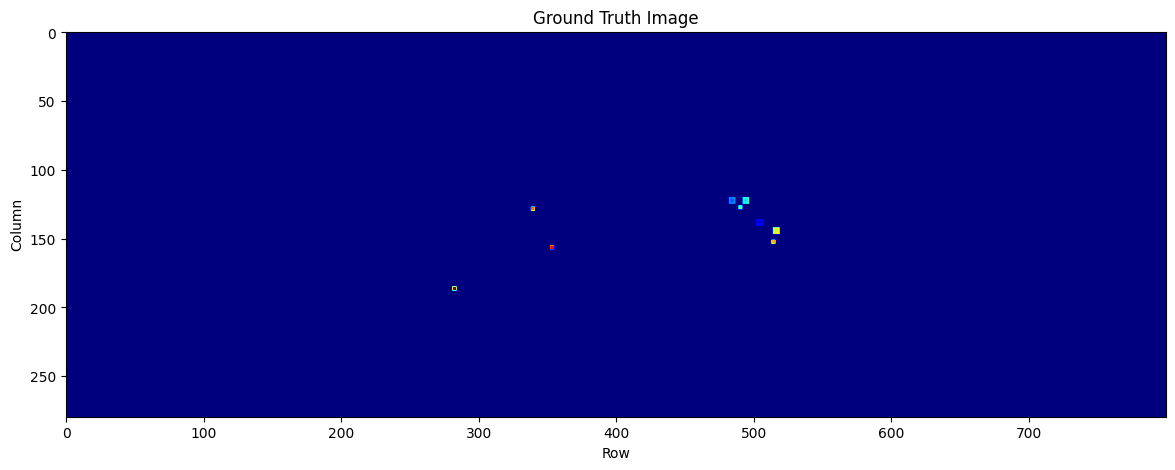

In [14]:
plt.figure(figsize=(15,5)) 
plt.imshow(gt_im, cmap='jet')
plt.xlabel('Row')
plt.ylabel('Column')
plt.title('Ground Truth Image')

# Connect Names

In [40]:
formulas = ['MF', 'ACE']

import pandas as pd

roi_guard_name = ['F1 Site 12 - Guard',
 'F2 Site 5 - Guard',
 'F3a Site 4 - Guard',
 'F3b Site 3 - Guard',
 'F4a Site 11 - Guard',
 'F4b Site 10 - Guard',
 'V1 Vehicle 3 - Guard',
 'V2 Vehicle 4 - Guard',
 'V3 Vehicle 5 - Guard']

roi_sub_name = ['F1 Site 12 - Sub',
 'F2 Site 5 - Sub',
 'F3a Site 4 - Sub',
 'F3b Site 3 - Sub',
 'F4a Site 11 - Sub',
 'F4b Site 10 - Sub',
 'V1 Vehicle 3 - Sub',
 'V2 Vehicle 4 - Sub',
 'V3 Vehicle 5 - Sub']
roi_idx = [1,4,7,9,12,14,16,18,20]

roi_full_name = ['F1 Site 12 - Full',
 'F2 Site 5 - Full',
 'F3a Site 4 - Full',
 'place_holder',
 'F4a Site 11 - Full',
 'place_holder',
 'place_holder',
 'place_holder',
 'place_holder']
roi_full_idx = [0,3,6,0,11] #0 as placeholder

detector_class_name = ['F1_Cloth_Red',
 'F2_Nylon_Yellow',
 'F3a_Cloth_Blue',
 'F3b_Cloth_Blue',
 'F4a_Nylon_Maroon',
 'F4b_Nylon_Maroon',
 'V1_field_spectrum',
 'V2a_field_spectrum',
 'V3_field_spectrum']
detector_class_idx = [17, 15, 13, 13, 11, 11, 3, 1, 0]

# Scatterplots

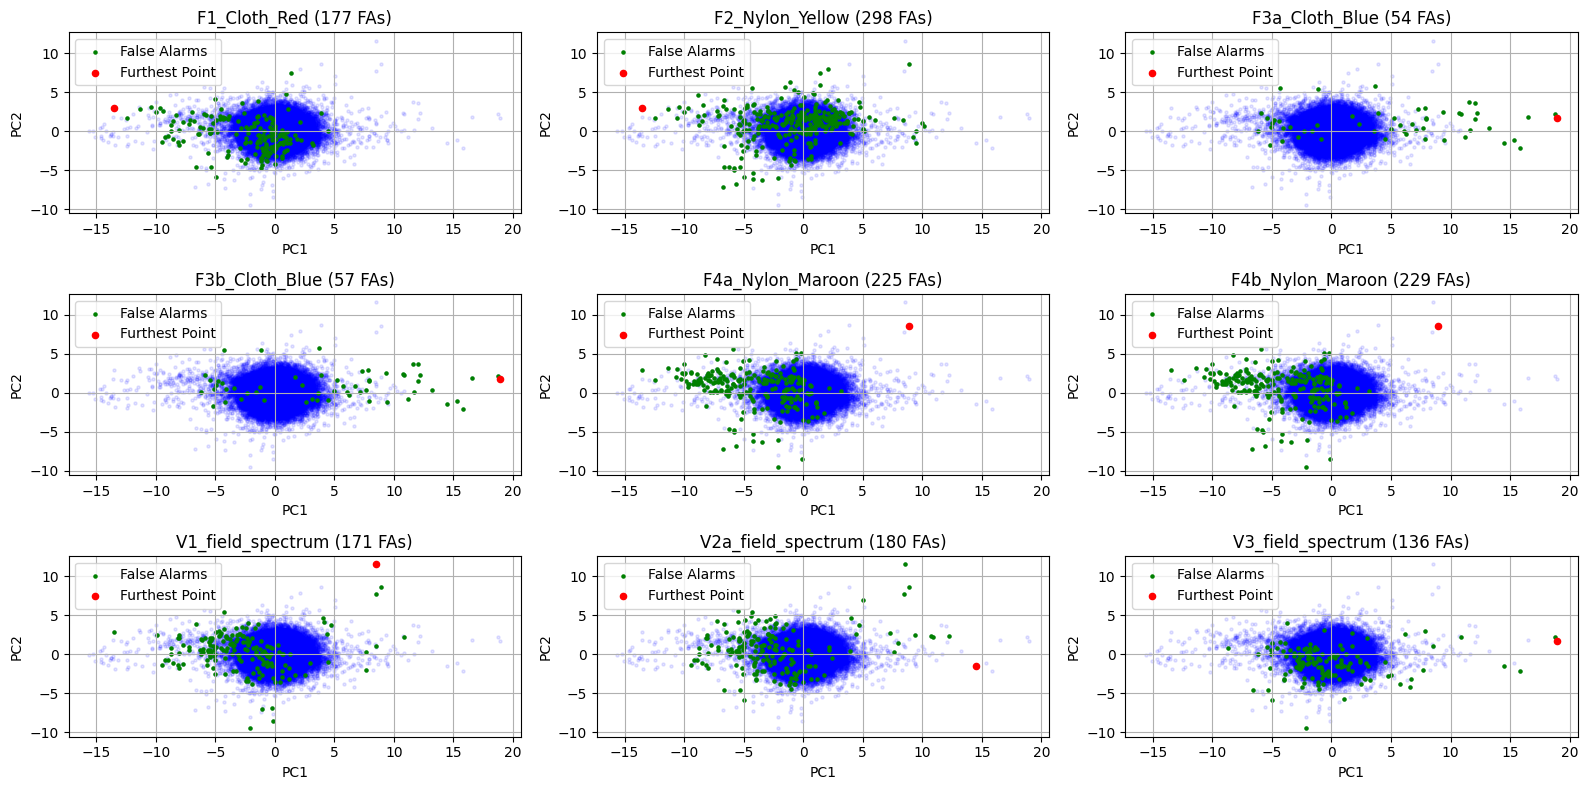

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


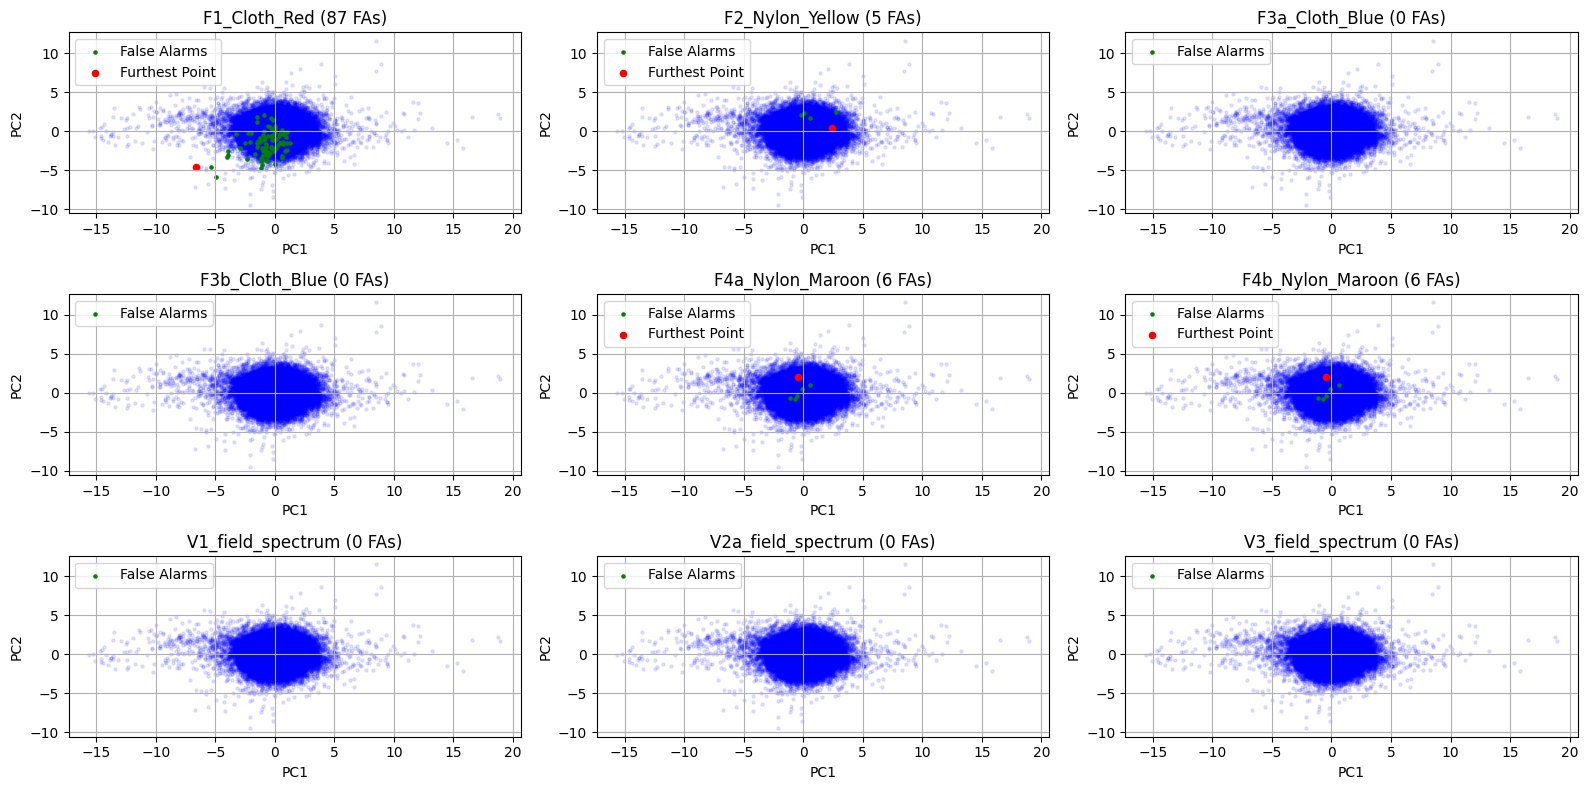

In [16]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = 9

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to easily index

    plot_idx = 0


    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold < 0] = 0
        detections = np.where(MF_threshold > m + 6 * s)
        detections = [list(i) for i in zip(detections[0], detections[1])]

        # ROIS
        rois = groundtruth_classes[roi_sub_name[i]]['locations']
        if i in [0,1,2,4]:
            rois_full = groundtruth_classes[roi_full_name[i]]['locations']
            rois = rois + rois_full
            rois = [[int(num) for num in sublist] for sublist in rois]
        else:
            rois = [[int(num) for num in sublist] for sublist in rois]

        # Guards
        guards = groundtruth_classes[roi_guard_name[i]]['locations']
        guards = [[int(num) for num in sublist] for sublist in guards]

        false_alarms = [item for item in detections if item not in rois and item not in guards]
        true_positives = [item for item in detections if item in rois]


        # Scatter plot
        PC1 = 30
        PC2 = 61

        # Reshape the whitened image spectra to image shape
        WimArr = np.reshape(WimList, (im.nrows, im.ncols, im.nbands))
        x_list = []
        y_list = []
        F1_idx = false_alarms
        for k in range(len(F1_idx)):
            lst = WimArr[F1_idx[k][0], F1_idx[k][1], :].flatten()
            x_list.append(lst[PC1])
            y_list.append(lst[PC2])

        # Calculate the center point
        center_x = np.mean(x_list)
        center_y = np.mean(y_list)

        # Calculate distances from the center
        distances = np.sqrt((x_list - center_x) ** 2 + (y_list - center_y) ** 2)

        # Find the index of the furthest point
        furthest_index = np.argmax(distances) if len(distances) > 0 else None

        ax = axes[plot_idx]
        ax.scatter(WimList[:, PC1], WimList[:, PC2], s=5, c='b', alpha=0.1)
        ax.scatter(x_list, y_list, c='g', s=5, label='False Alarms')
        if furthest_index is not None:
            ax.scatter(x_list[furthest_index], y_list[furthest_index], color='red', s=20, label='Furthest Point')
        ax.set_title(f'{detector_class_name[i]} ({len(false_alarms)} FAs)')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True)
        ax.legend()
        
        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Histograms

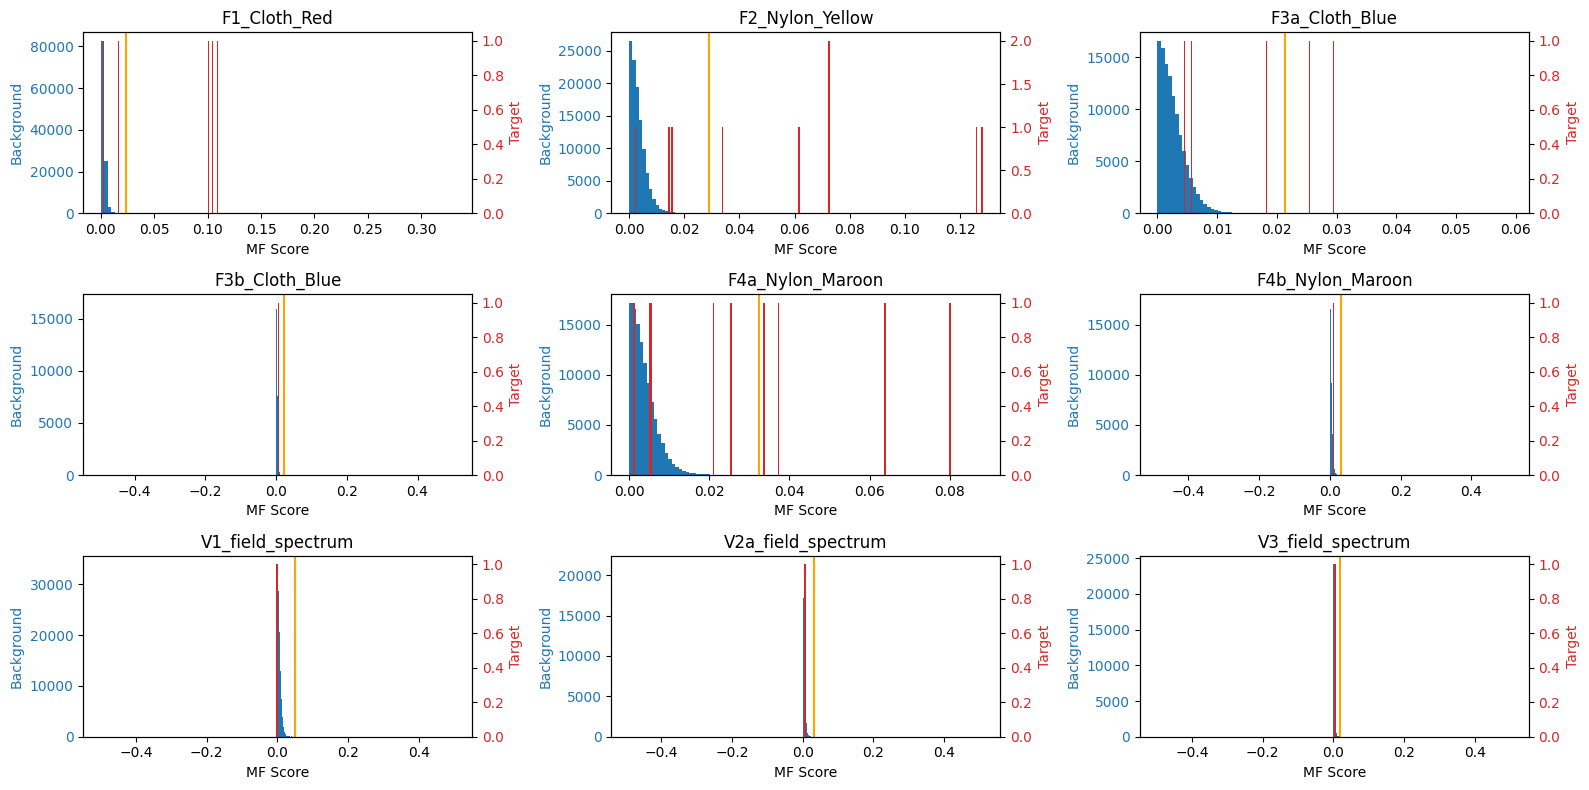

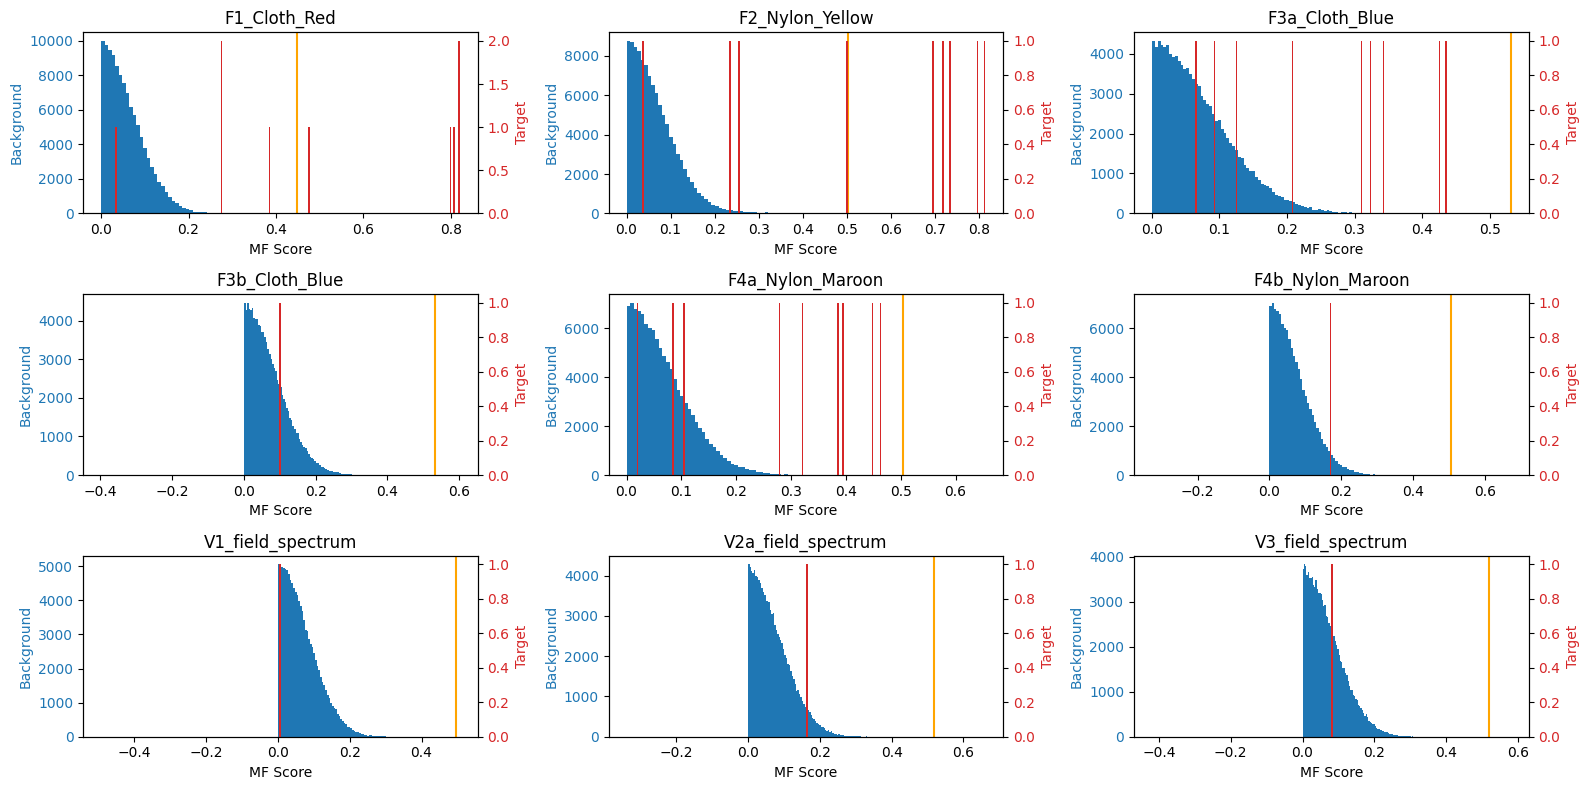

In [17]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = len(detector_class_idx)

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to index easily

    plot_idx = 0

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)


        # Histogram data
        if i in [0,1,2,4]:
            MD_within_class = MF_threshold.flatten()[np.where((gt_list == roi_idx[i]+1) | (gt_list == roi_full_idx[i]+1))] #add one to skip ground_truth class
        else:
            MD_within_class = MF_threshold.flatten()[np.where(gt_list == roi_idx[i]+1)[0]] #add one to skip ground_truth class
        MD_other_classes = MF_threshold.flatten()[np.where(gt_list != roi_idx[i]+1)[0]] #add one to skip ground_truth class


        ax1 = axes[plot_idx]  # Access the current subplot
        # Background histogram
        color = 'tab:blue'
        ax1.set_xlabel('MF Score')
        ax1.set_ylabel('Background', color=color)
        ax1.hist(MD_other_classes[MD_other_classes > 0], bins=100, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        # Target histogram using secondary y-axis
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel('Target', color=color)
        ax2.hist(MD_within_class, bins = 200, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        # Plot threshold line
        ax1.axvline(m + 6 * s, color='orange')#, label=f'Threshold (6SD), {z}={(m + 6 * s):.3f}')

        # Title and legend
        ax1.set_title(f'{detector_class_name[i]}')
        #ax1.grid(True)
        #ax1.legend(loc='upper right')

        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


# False Alarm Rates

In [ ]:
fa_rate = []
tp_rate = []

for z in formulas:

    mf_fa_rate = []
    mf_tp_rate = []

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:,:,detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:,:,detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold<0] = 0
        detections = np.where(MF_threshold>m+6*s)
        detections = [list(i) for i in zip(detections[0], detections[1])]

        # ROIS
        rois = groundtruth_classes[roi_sub_name[i]]['locations']
        rois = [[int(num) for num in sublist] for sublist in rois]

        #Guards
        guards = groundtruth_classes[roi_guard_name[i]]['locations']
        guards = [[int(num) for num in sublist] for sublist in guards]

        false_alarms = [item for item in detections if item not in rois and item not in guards]
        true_positives = [item for item in detections if item in rois]
        mf_fa_rate.append(len(false_alarms)/len(rois))
        mf_tp_rate.append(len(true_positives)/len(rois))

    ############ FALSE ALARM RATE TABLE ############
    fa_rate.append(mf_fa_rate)
    tp_rate.append(mf_tp_rate)

# False Alarm Rates
df = pd.DataFrame(fa_rate, columns=detector_class_name)
df.index = formulas

# True Positive Rates
df1 = pd.DataFrame(tp_rate, columns=detector_class_name)
df1.index = formulas

In [19]:
# False Alarm Rates
df = pd.DataFrame(fa_rate, columns=detector_class_name)
df.index = formulas
df

F1_Cloth_Red  F2_Nylon_Yellow  F3a_Cloth_Blue  F3b_Cloth_Blue  \
MF          22.25           37.375            6.75            57.0   
ACE         11.00            0.750            0.00             0.0   

     F4a_Nylon_Maroon  F4b_Nylon_Maroon  V1_field_spectrum  \
MF              28.25             229.0              171.0   
ACE              0.75               6.0                0.0   

     V2a_field_spectrum  V3_field_spectrum  
MF                180.0              136.0  
ACE                 0.0                0.0

In [20]:
# True Positive Rates
df1 = pd.DataFrame(tp_rate, columns=detector_class_name)
df1.index = formulas
df1

F1_Cloth_Red  F2_Nylon_Yellow  F3a_Cloth_Blue  F3b_Cloth_Blue  \
MF          0.625            0.625           0.375             0.0   
ACE         0.500            0.500           0.000             0.0   

     F4a_Nylon_Maroon  F4b_Nylon_Maroon  V1_field_spectrum  \
MF              0.375               0.0                0.0   
ACE             0.000               0.0                0.0   

     V2a_field_spectrum  V3_field_spectrum  
MF                  0.0                0.0  
ACE                 0.0                0.0

# Target Visuals over Image

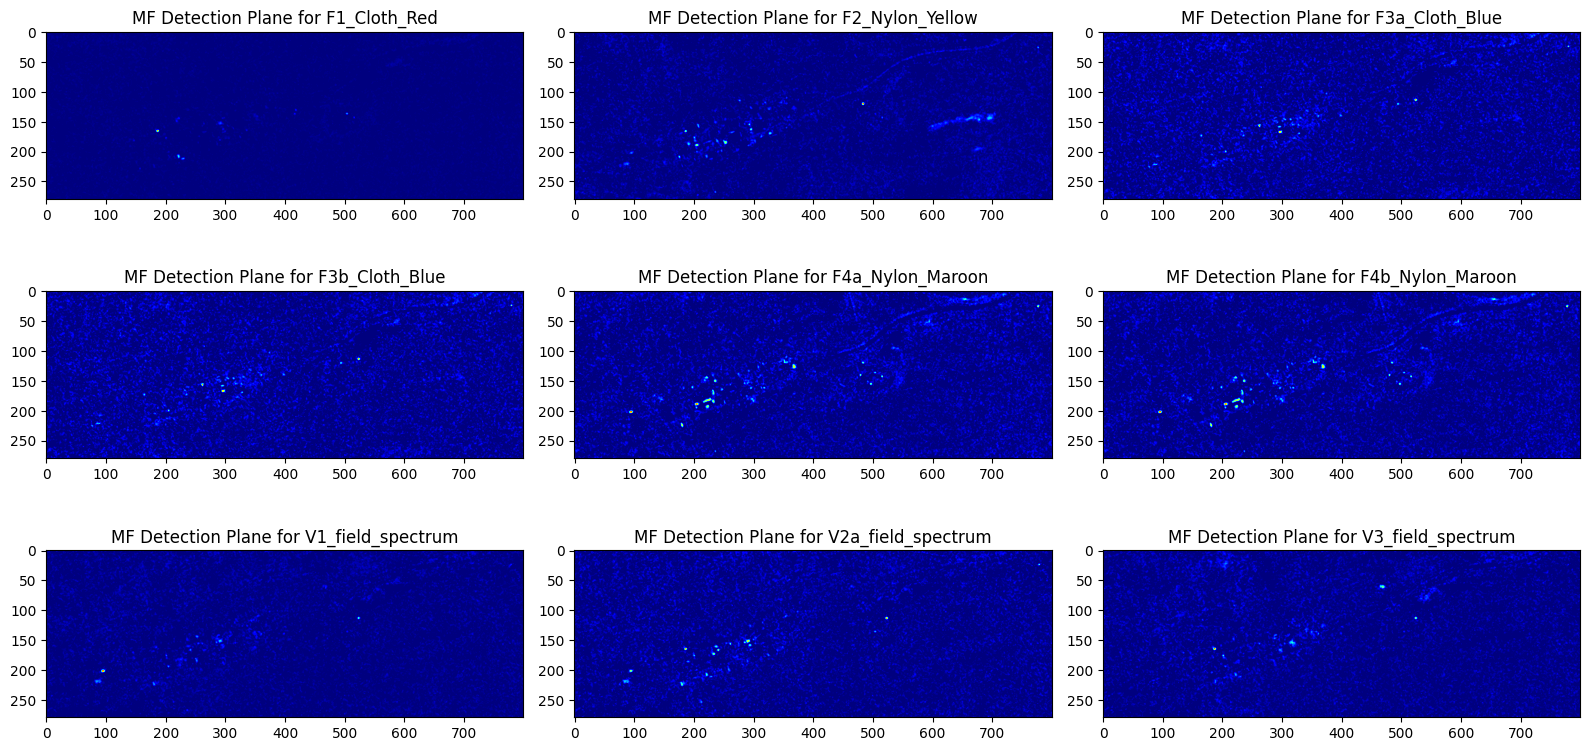

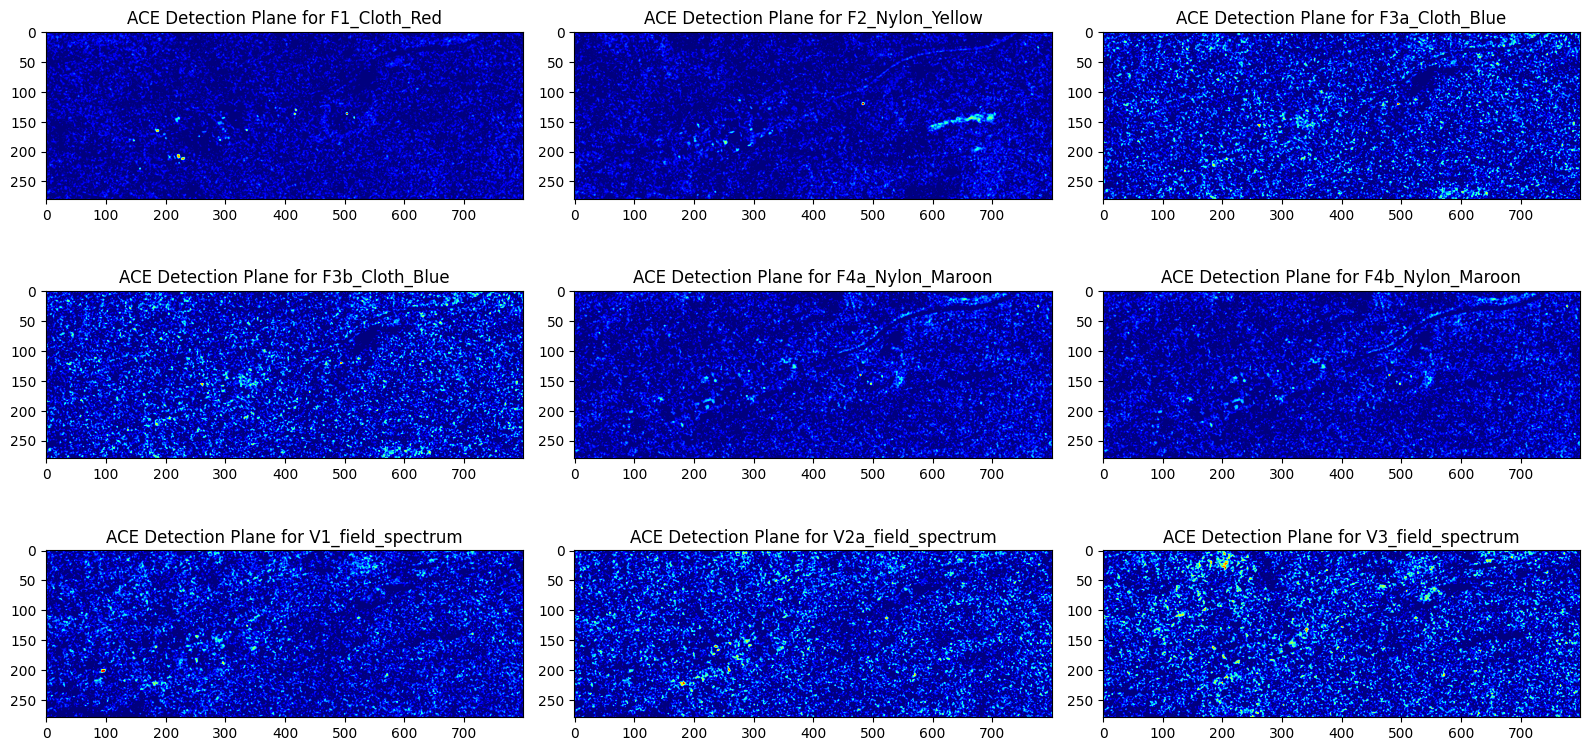

In [27]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = len(detector_class_idx)

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to index easily

    plot_idx = 0

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)

        #Plot
        ax1 = axes[plot_idx]  # Access the current subplot
        #MF_threshold[MF_threshold<0] = 0
        ax1.imshow(MF_threshold, cmap='jet')

        # Title and legend
        ax1.set_title(f'{z} Detection Plane for {detector_class_name[i]}')

        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Thresholding Histograms

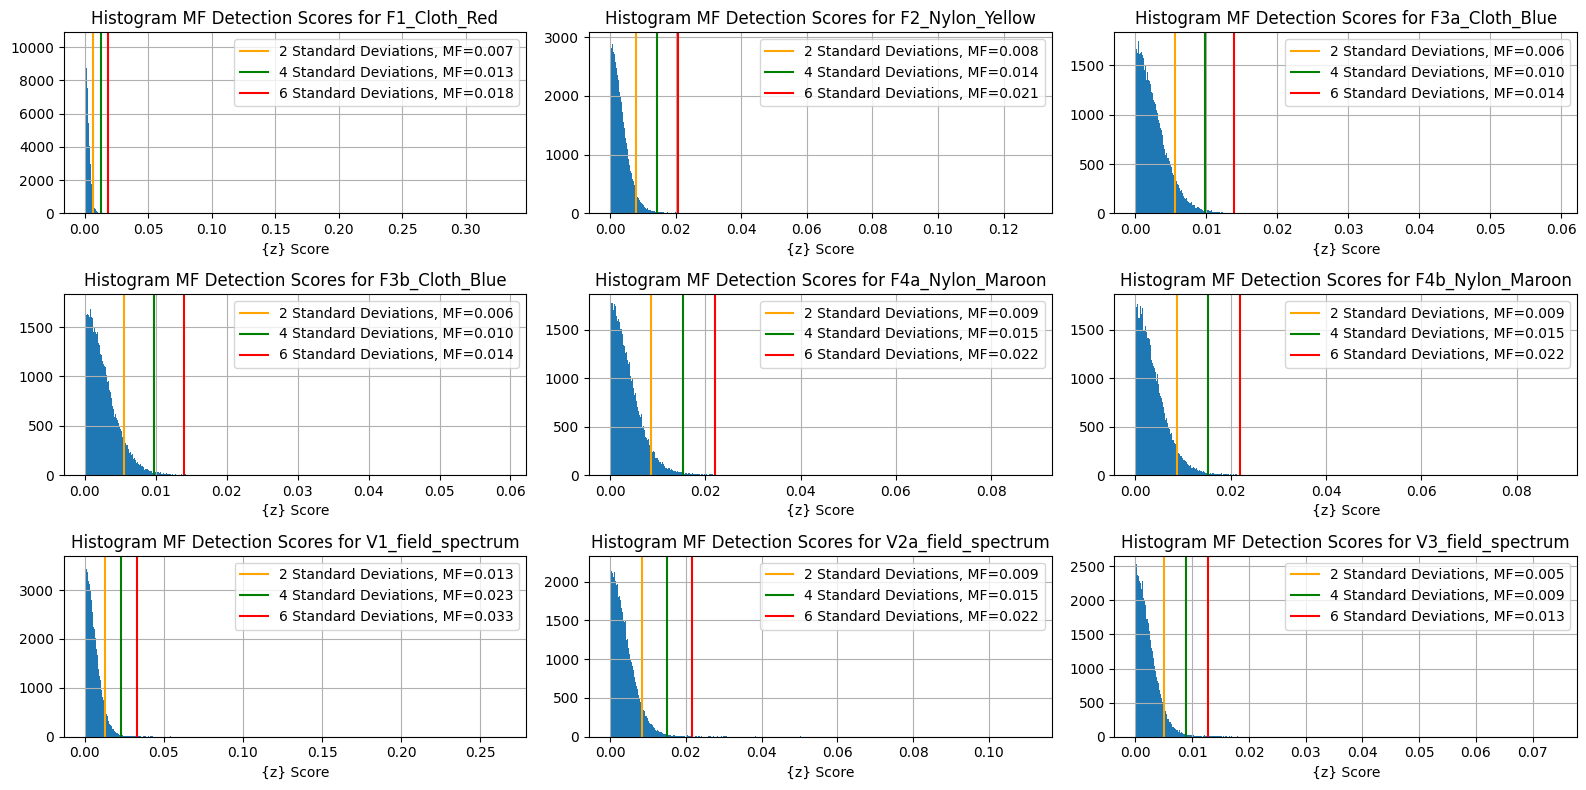

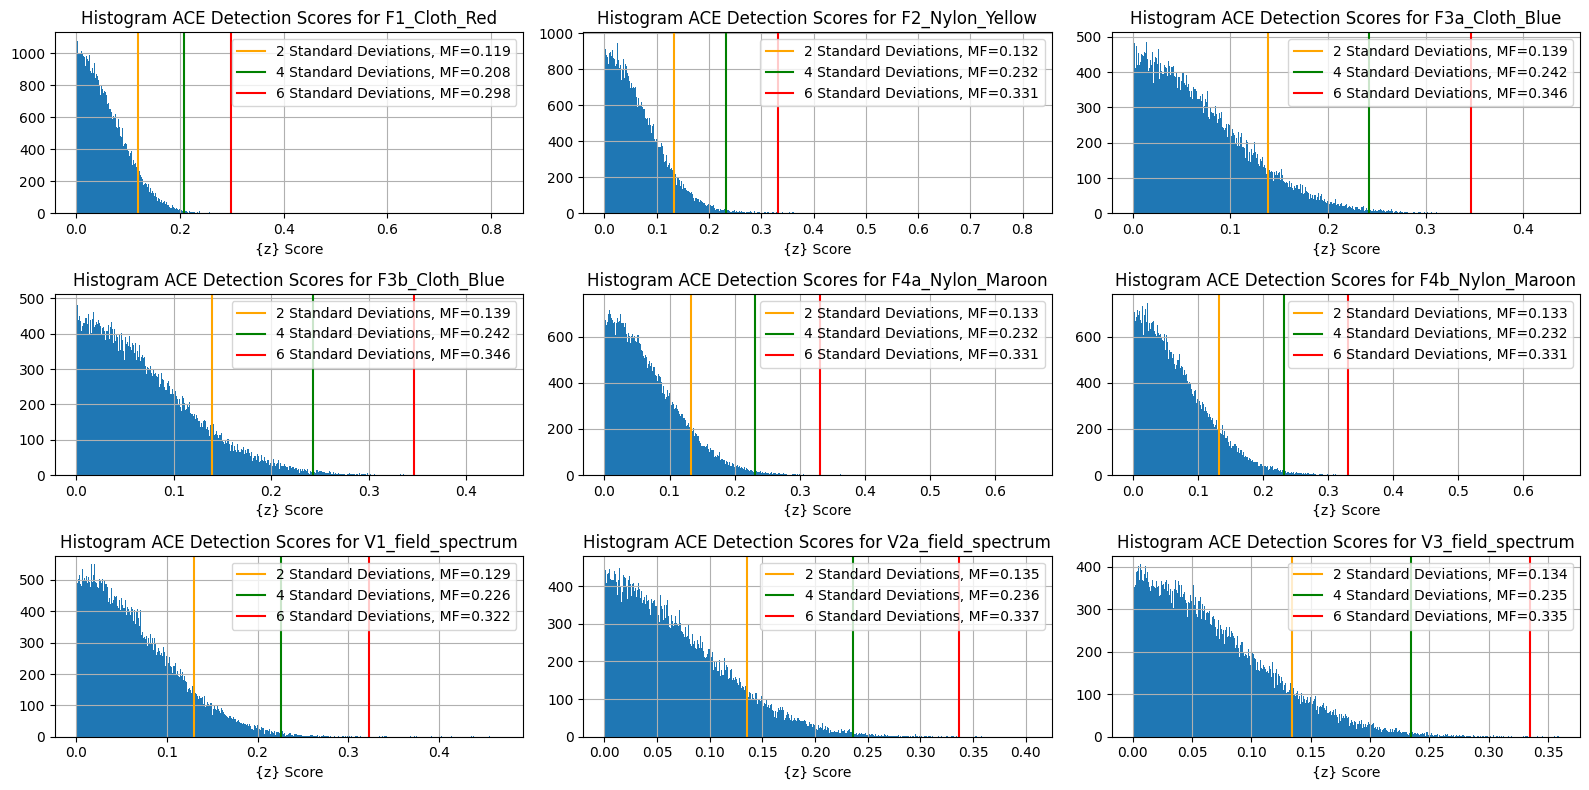

In [34]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = len(detector_class_idx)

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to index easily

    plot_idx = 0

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold<0] = 0

        #Plot
        ax1 = axes[plot_idx]  # Access the current subplot
        ax1.hist((MF_threshold[MF_threshold>0]).flatten(), bins=1000);
        ax1.set_title(f'Histogram {z} Detection Scores for {detector_class_name[i]}')
        ax1.axvline(m+2*s, color='orange', label=f'2 Standard Deviations, MF={(m+2*s):.3f}')
        ax1.axvline(m+4*s, color='green', label=f'4 Standard Deviations, MF={(m+4*s):.3f}')
        ax1.axvline(m+6*s, color='red', label=f'6 Standard Deviations, MF={(m+6*s):.3f}')
        ax1.legend()
        ax1.grid(True)
        ax1.set_xlabel('{z} Score');

        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# RGB image that is gray at locations without detections

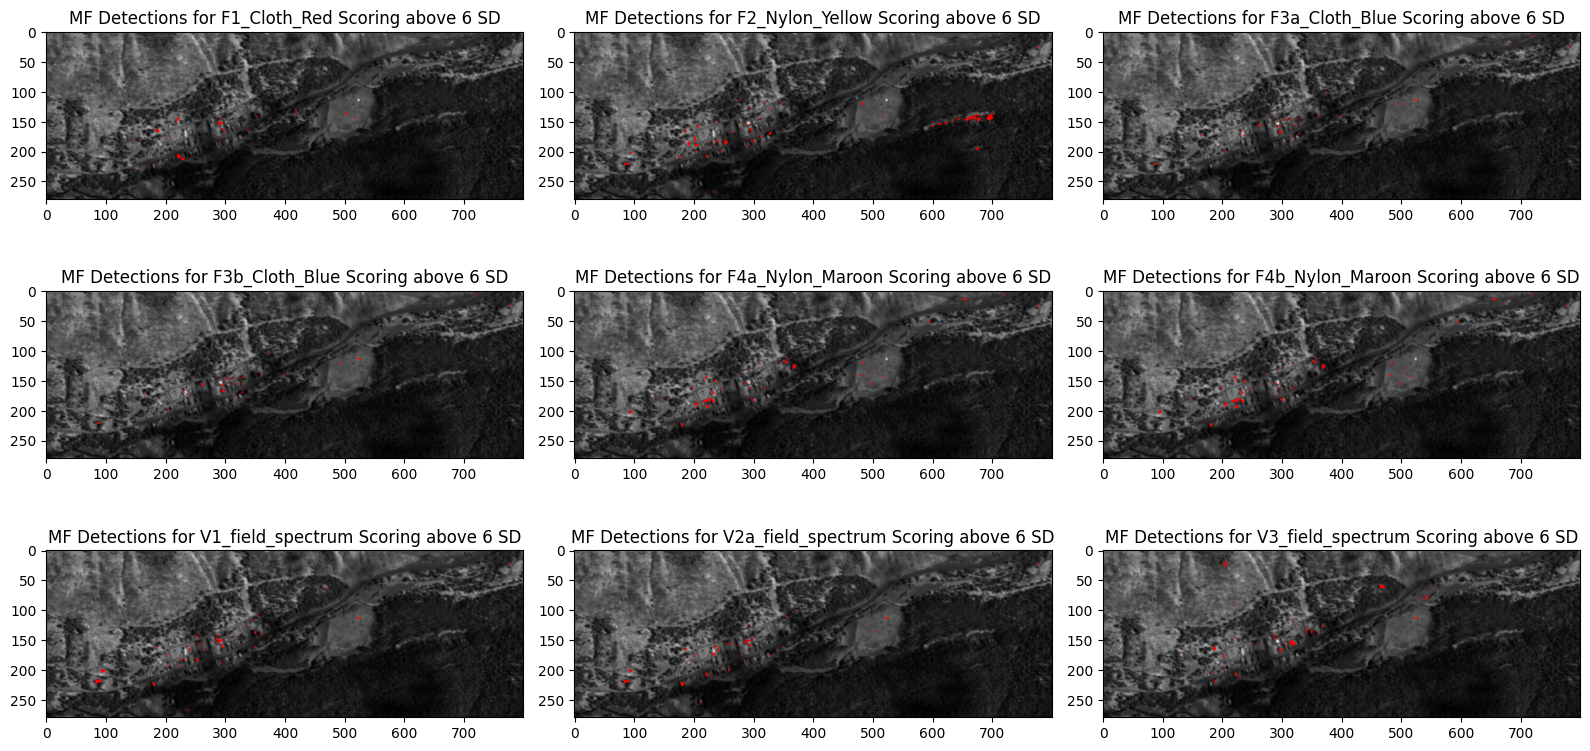

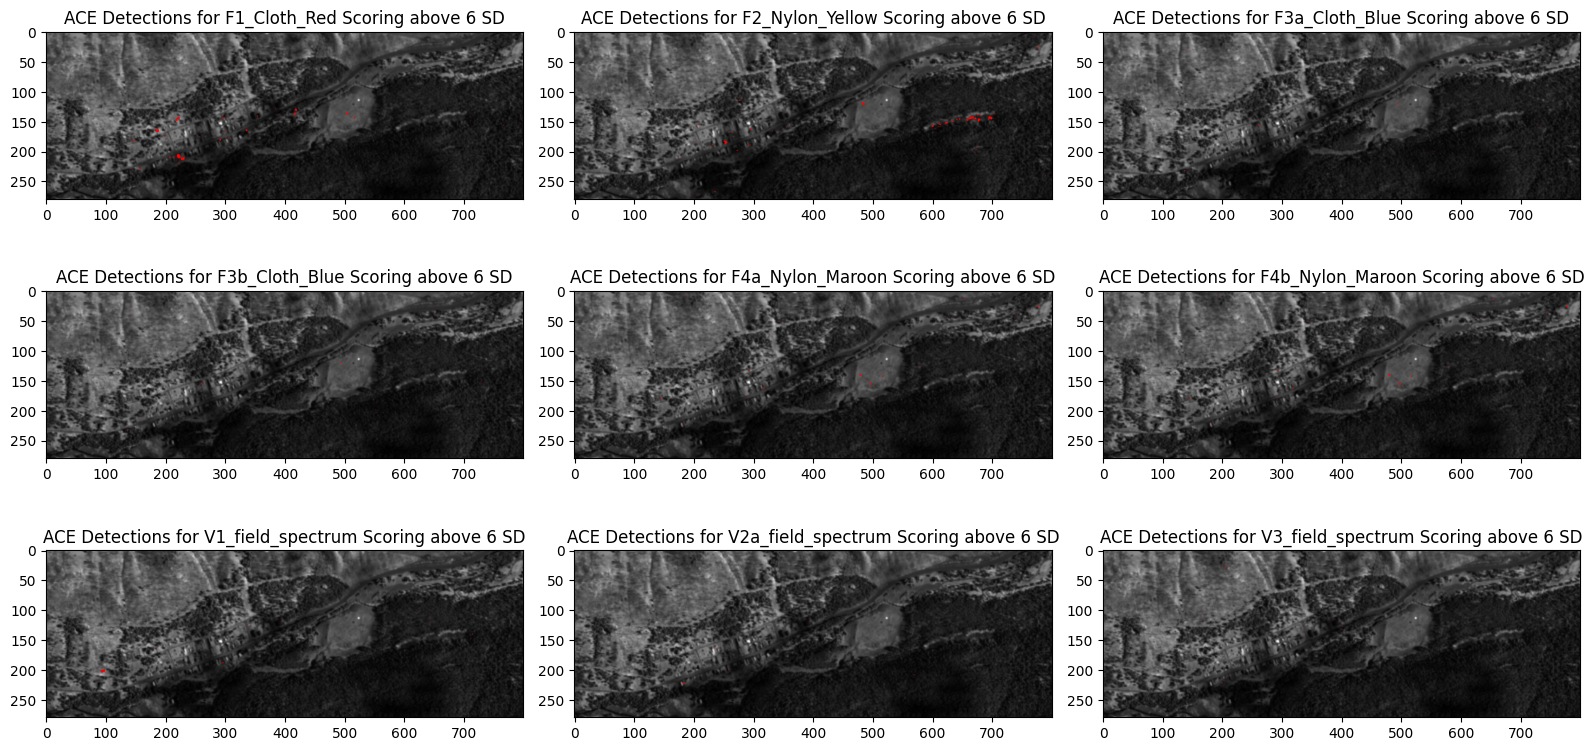

In [37]:
for z in formulas:

    # Determine the total number of subplots needed
    num_subplots = len(detector_class_idx)

    # Create a single figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(16, 8))
    axes = axes.flatten()  # Flatten axes to index easily

    plot_idx = 0

    for i in range(len(detector_class_idx)):
        # Detected Targets
        if z == 'MF':
            MF_threshold = MF[:, :, detector_class_idx[i]].squeeze()
        else:
            MF_threshold = ACE[:, :, detector_class_idx[i]].squeeze()
        m = np.mean(MF_threshold)
        s = np.std(MF_threshold)
        #MF_threshold[MF_threshold<0] = 0

        #Plot
        ax1 = axes[plot_idx]  # Access the current subplot
        # Create an RGB image that is gray at locations without detections, 
        # and red on pixels with above 6-standard deviation detection scores.
        detections = np.where(MF_threshold>m+6*s)
        # get the image band at 750nm, and stretch the values to be in 0-1
        band_750 = np.argmin(np.abs(wl-750)) # get the index for the band closest to wl=750
        image_detections_singleband = imArr[:,:,band_750].squeeze()
        image_detections_singleband = image_detections_singleband - np.min(image_detections_singleband)
        image_detections_singleband = image_detections_singleband/np.max(image_detections_singleband)
        # build a color RGB image from this one band, making the detection locations red
        image_detections_red = copy.deepcopy(image_detections_singleband) # copy here makes a copy of the array, so we don't alter the original array
        image_detections_green = copy.deepcopy(image_detections_singleband)
        image_detections_blue = copy.deepcopy(image_detections_singleband)
        image_detections_red[detections] = 0.99
        image_detections_green[detections] = 0
        image_detections_blue[detections] = 0
        image_detections_RGB = np.zeros((im.nrows,im.ncols,3))
        image_detections_RGB[:,:,0] = image_detections_red
        image_detections_RGB[:,:,1] = image_detections_green
        image_detections_RGB[:,:,2] = image_detections_blue
        #look at standard deviations to determine threshold for background/target separation - hard to set threshold because anomalies vs targets
        ax1.imshow(image_detections_RGB)
        ax1.set_title(f'{z} Detections for {detector_class_name[i]} Scoring above 6 SD');

        plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()